.!frame
Displayed Image Paths:
saved_image_0.png
saved_image_1.png
saved_image_2.png
saved_image_3.png


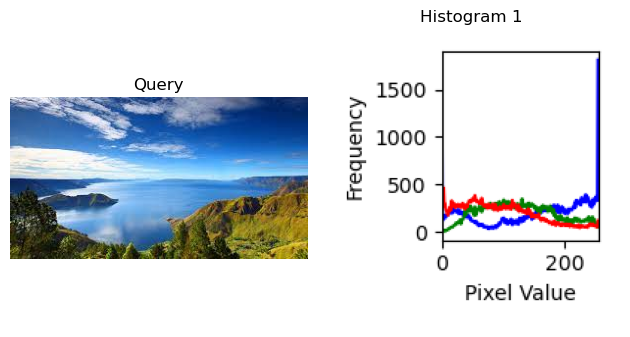

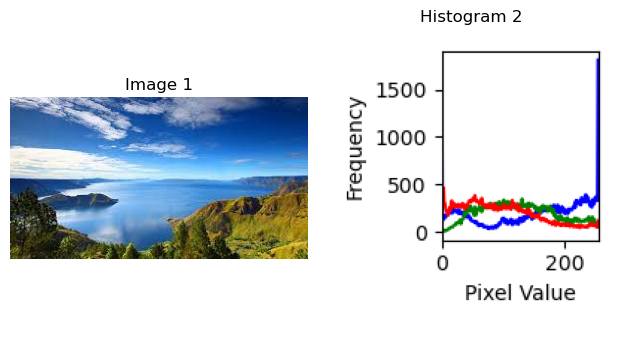

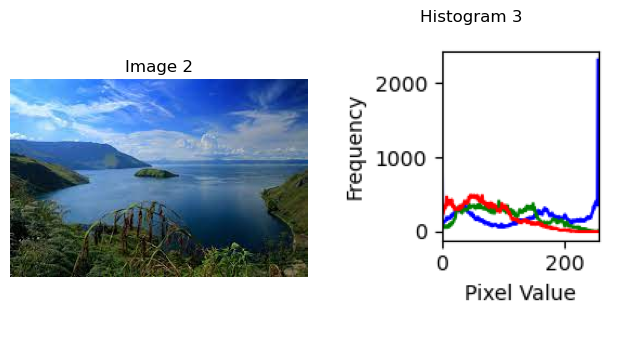

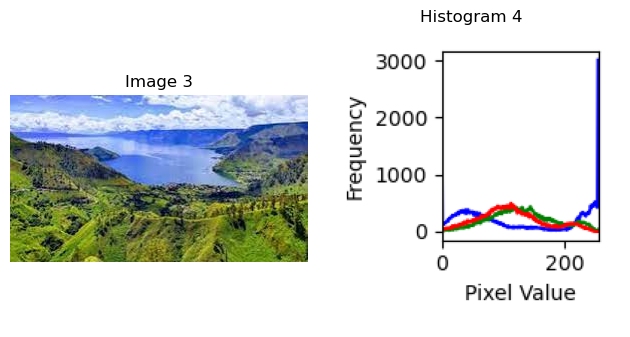

Displayed Image Paths:
saved_image_0.png
saved_image_1.png
saved_image_2.png
saved_image_3.png


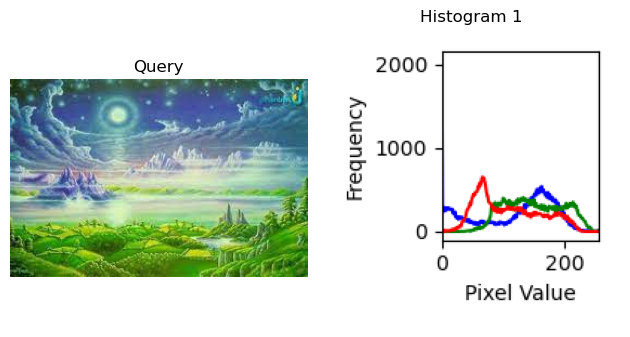

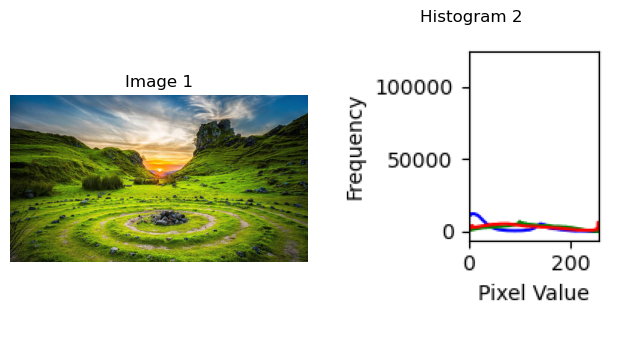

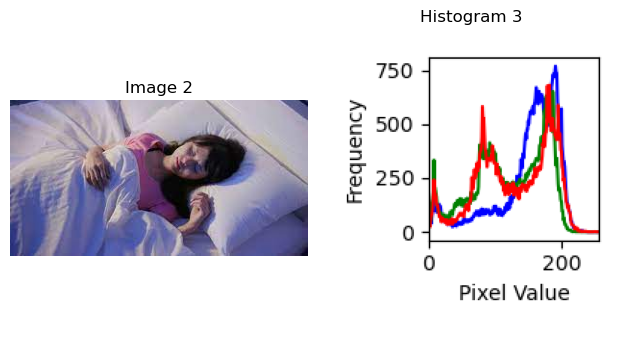

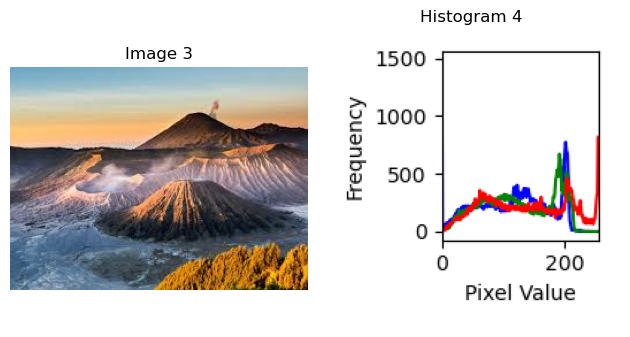

Displayed Image Paths:
saved_image_0.png
saved_image_1.png
saved_image_2.png
saved_image_3.png


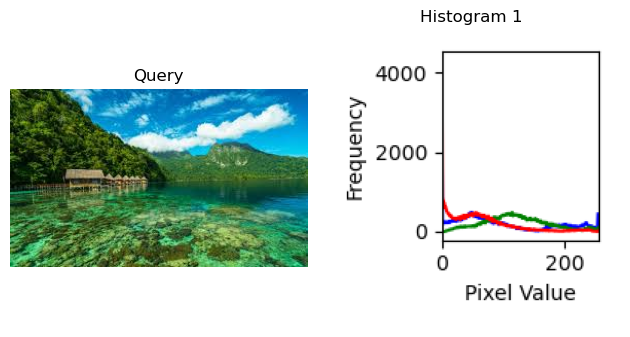

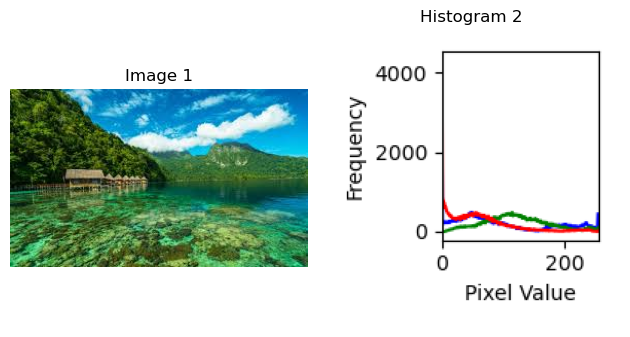

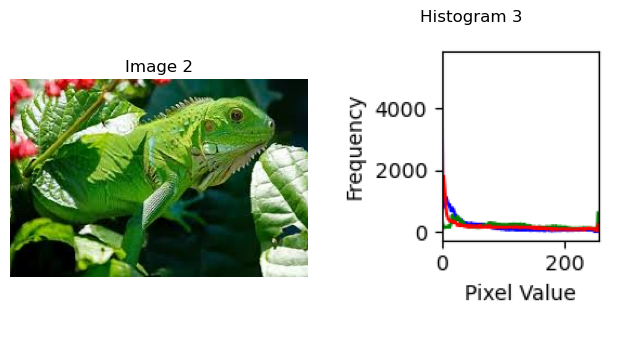

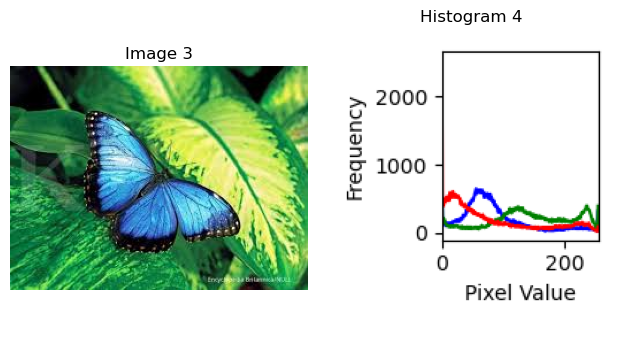

Displayed Image Paths:
saved_image_0.png
saved_image_1.png
saved_image_2.png
saved_image_3.png


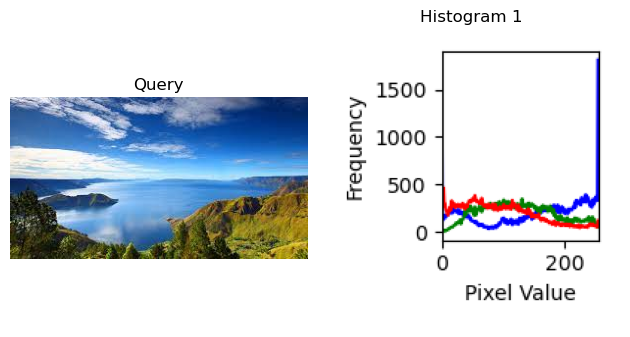

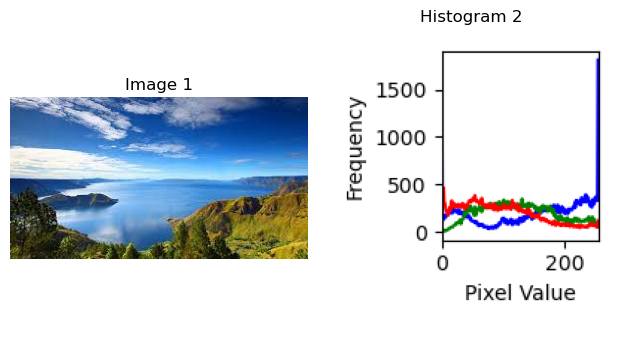

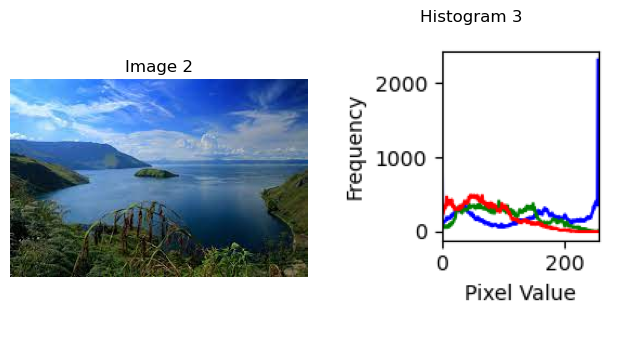

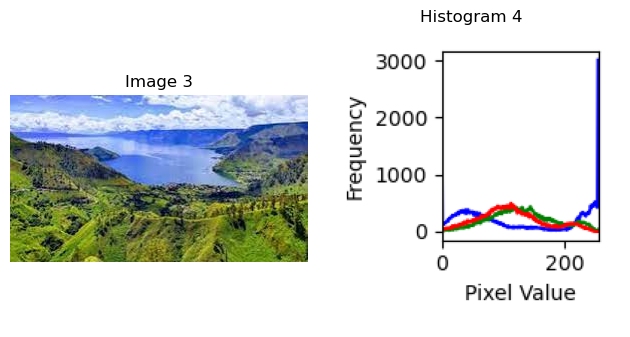

In [32]:
import cv2
import numpy as np
from tkinter import Tk, filedialog, ttk, StringVar, BOTTOM
from PIL import Image, ImageTk
import dropbox
import io
from io import BytesIO
import os
from concurrent.futures import ThreadPoolExecutor
import matplotlib.pyplot as plt

# Constants
DROPBOX_ACCESS_TOKEN = "sl.BoHe7em7wQumNT-pVGl7lji0Py1moHDmnj_G62OAkmqxKlZzdaREOToW4amOez3emTJVtLbC3h0RjcYmg2BXFdd2AdsPjqUEawYYagWp6KphOIn23b9q-X1o9Th4Cy4wAg7rDlMHBG9MaSP7iYd5oHM"
DROPBOX_TARGET_FOLDER = '/tes/'
IMAGE_EXTENSIONS = ('.png', '.jpg', '.jpeg')
DISPLAY_SIZE = (200, 200)
MAX_THREADS = 4  # Adjust based on your system
CACHE_DIR = "./image_cache/"

if not os.path.exists(CACHE_DIR):
    os.makedirs(CACHE_DIR)

dbx = dropbox.Dropbox(DROPBOX_ACCESS_TOKEN)
dropbox_image_cache = []
dropbox_histogram_cache = {}

#digunakan untuk memunculkan dialog pemilihan file ketika Anda ingin memilih gambar (dalam format .png, .jpg, atau .jpeg) sebagai gambar query.
def choose_file():
    return filedialog.askopenfilename(filetypes=[("Image files", ".png;.jpg;*.jpeg")])

#Mengambil gambar dari folder Dropbox dan menghitung histogram untuk setiap gambar, kemudian menyimpannya dalam cache untuk digunakan nanti.
def fetch_files_from_dropbox(force_refresh=False, limit=50):
    global dropbox_image_cache, dropbox_histogram_cache
    if not force_refresh and dropbox_image_cache:
        return dropbox_image_cache, dropbox_histogram_cache
    
    file_data = []
    hist_data = {}
    cursor = None

    try:
        while True:
            if cursor:
                response = dbx.files_list_folder_continue(cursor)
            else:
                response = dbx.files_list_folder(DROPBOX_TARGET_FOLDER, limit=limit)

            for entry in response.entries:
                if isinstance(entry, dropbox.files.FileMetadata) and entry.name.endswith(IMAGE_EXTENSIONS):
                    cached_image_path = os.path.join(CACHE_DIR, entry.name)
                    
                    if not os.path.exists(cached_image_path) or force_refresh:
                        metadata, res = dbx.files_download(path=entry.path_lower)
                        with open(cached_image_path, "wb") as f:
                            f.write(res.content)

                    file_data.append(cached_image_path)
                    
                    if cached_image_path not in dropbox_histogram_cache:
                        image = cv2.imread(cached_image_path)
                        hist = compute_histogram(image)
                        hist_data[cached_image_path] = hist
            
            if not response.has_more:
                break
            
            cursor = response.cursor

        dropbox_image_cache = file_data
        dropbox_histogram_cache.update(hist_data)
    except Exception as e:
        status_var.set(f"Error fetching images: {str(e)}")

    return dropbox_image_cache, dropbox_histogram_cache

#digunakan untuk mengonversi data gambar yang ada dalam bentuk buffer menjadi objek gambar OpenCV (cv2) yang dapat digunakan untuk pemrosesan gambar selanjutnya.
def get_cv2_image_from_memory(buffer):
    image_stream = io.BytesIO(buffer)
    image_stream.seek(0)
    file_bytes = np.asarray(bytearray(image_stream.read()), dtype=np.uint8)
    image = cv2.imdecode(file_bytes, cv2.IMREAD_COLOR)
    return image

#Menghitung histogram dari gambar yang diberikan menggunakan OpenCV.
def compute_histogram(image):
    hist = []
    for channel in range(image.shape[2]):
        h = cv2.calcHist([image], [channel], None, [256], [0, 256])
        hist.append(h)
    return np.concatenate(hist).ravel()

#Mencari gambar yang mirip dengan gambar query berdasarkan perbandingan histogram.
def find_matches(query_image_path):
    query_image = cv2.imread(query_image_path)
    query_hist = compute_histogram(query_image)
    
    scores = {}
    file_path_list, hist_data = fetch_files_from_dropbox()

    #digunakan untuk menghitung skor kesamaan antara histogram dari gambar query 
    #dengan histogram gambar lainnya yang diambil dari Dropbox. Skor ini mengukur sejauh mana histogram-histogram tersebut mirip 
    def compute_score(file_path):
        other_hist = hist_data[file_path]
        score = cv2.compareHist(query_hist, other_hist, cv2.HISTCMP_CORREL)
        return file_path, score

    with ThreadPoolExecutor(max_workers=MAX_THREADS) as executor:
        results = executor.map(compute_score, file_path_list)
        for file_path, score in results:
            scores[file_path] = score

    top_matches = [item[0] for item in sorted(scores.items(), key=lambda x: x[1], reverse=True)[:3]]
    
    return top_matches

# Digunakan untuk menampilkan plot histogram.
def plot_histogram(image, title):
    color = ('b', 'g', 'r')
    for i, col in enumerate(color):
        histr = cv2.calcHist([image], [i], None, [256], [0, 256])
        plt.plot(histr, color=col)
        plt.xlim([0, 256])
    plt.title(title)
    plt.show()


#Menghasilkan gambar histogram yang lebih kecil dari histogram gambar yang diberikan.
def get_histogram_image(image):
    """
    Generates a smaller image of the histogram for the given image.
    """
    color = ('b', 'g', 'r')
    plt.figure(figsize=(2, 2))  # ukuran (width, height)
    for i, col in enumerate(color):
        histr = cv2.calcHist([image], [i], None, [256], [0, 256])
        plt.plot(histr, color=col)
        plt.xlim([0, 256])
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.tight_layout()

    # Convert the matplotlib plot ke BytesIO object
    buf = BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    plt.close()
    return buf

#Digunakan untuk menampilkan gambar dan histogramnya dalam GUI.
def display_image_and_histogram(img_source, row, col, frame, title):
    global image_references
    img_np = cv2.imread(img_source)
    img_pil = Image.fromarray(cv2.cvtColor(img_np, cv2.COLOR_BGR2RGB)).resize(DISPLAY_SIZE)
    ttk.Label(frame, text=title, font=("Arial", 12, "bold")).grid(row=0, column=col, padx=10, pady=10)
    img_photo = ImageTk.PhotoImage(img_pil)
    ttk.Label(frame, image=img_photo).grid(row=1, column=col, padx=10, pady=10)
    image_references.append(img_photo)

    # Save the image to a file
    img_save_path = f"saved_image_{col}.png"
    cv2.imwrite(img_save_path, img_np)

    # Display smaller histogram below the image
    hist_image = Image.open(get_histogram_image(img_np))
    hist_photo = ImageTk.PhotoImage(hist_image)
    ttk.Label(frame, image=hist_photo).grid(row=2, column=col, padx=10, pady=10)
    image_references.append(hist_photo)

    return img_save_path  # the simpan gambar

    

#Dipanggil saat pengguna memilih gambar query. Menampilkan gambar query dan gambar yang mirip dalam GUI.
def process_and_display():
    query_image_path = choose_file()
    if not query_image_path:
        return

    matches = find_matches(query_image_path)
    displayed_image_paths = []  # Create a list to store displayed image paths
    for widget in result_frame.winfo_children():
        widget.destroy()

    # Display the query image and capture its path
    query_image_displayed_path = display_image_and_histogram(query_image_path, 0, 0, result_frame, "Query Image")
    displayed_image_paths.append(query_image_displayed_path)

    # Display the matching images and capture their paths
    for idx, match_path in enumerate(matches):
        match_displayed_path = display_image_and_histogram(match_path, 0, idx + 1, result_frame, f"Match {idx + 1}")
        displayed_image_paths.append(match_displayed_path)

    # Print the paths of the displayed images
    print("Displayed Image Paths:")
    for path in displayed_image_paths:
        print(path)

    # Display the saved images using Matplotlib with titles and histograms
    for idx, path in enumerate(displayed_image_paths):
        img = cv2.imread(path)
        plt.figure()

        # Add title
        plt.subplot(1, 2, 1)
        if idx == 0:  # Set the title for the first image to "Query"
            plt.title("Query")
        else:
            plt.title(f"Image {idx}")
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis('off')

        # Add histogram
        plt.subplot(1, 2, 2)
        hist_image = Image.open(get_histogram_image(img))
        plt.imshow(hist_image)
        plt.title(f"Histogram {idx + 1}")
        plt.axis('off')

        plt.tight_layout()
        plt.show()

#Tkinter GUI: Ini adalah bagian yang menginisialisasi antarmuka pengguna Tkinter. 
# Ini mencakup tombol untuk memilih gambar query dan area di mana gambar dan histogram akan ditampilkan.
root = Tk()
root.title("Image Matching App")
root.geometry("900x750")

style = ttk.Style(root)
style.configure("TFrame", background="#e1e1e1")
style.configure("TButton", padding=(10, 5), font=("Arial", 12))
style.configure("TLabel", background="#e1e1e1", font=("Arial", 10))

ttk.Button(root, text="Select Query Image", command=process_and_display).pack(pady=20)

result_frame = ttk.Frame(root)
result_frame.pack(pady=20, padx=20, fill="both", expand=True)
print(result_frame)

status_var = StringVar()
status_var.set(f"Fetching images from Dropbox folder: {DROPBOX_TARGET_FOLDER}")
status_bar = ttk.Label(root, textvariable=status_var, relief="sunken", anchor="w")
status_bar.pack(side=BOTTOM, fill="x")

image_references = []

root.mainloop()